In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_007"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, RandomResizedCrop(size, min_scale=0.75)]
    aug_tfm = aug_transforms(flip_vert=True,  
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing())
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

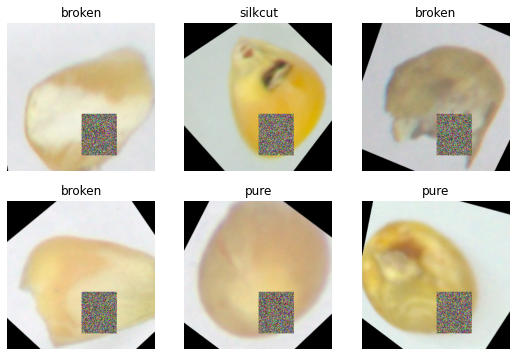

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [11]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
#     dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                 loss_func=CrossEntropyLossFlat(), metrics=[accuracy], splitter=timm_split).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [12]:
n_epo = 10; base_lr = 5e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_007_convnext_tiny_256_bs32_epo10_ft


In [14]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            wandb.define_metric('accuracy', hidden=False, summary="max")
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=timm_split).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),WandbCallback(log_preds=None)]
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.022702,0.851094,0.668063,00:33


Better model found at epoch 0 with accuracy value: 0.6680628061294556.


epoch,train_loss,valid_loss,accuracy,time
0,0.772760,0.660800,0.734380,00:44
1,0.708147,0.629277,0.749389,00:44
2,0.701388,0.624018,0.760209,00:44
3,0.651446,0.551359,0.782897,00:44
4,0.607261,0.583679,0.771030,00:44
5,0.574717,0.534249,0.783944,00:44
6,0.508762,0.503053,0.796161,00:44
7,0.458775,0.508963,0.795462,00:44
8,0.478485,0.507387,0.797208,00:44
9,0.467640,0.501794,0.794764,00:44


Better model found at epoch 0 with accuracy value: 0.7343804240226746.
Better model found at epoch 1 with accuracy value: 0.7493891716003418.
Better model found at epoch 2 with accuracy value: 0.7602094411849976.
Better model found at epoch 3 with accuracy value: 0.7828970551490784.
Better model found at epoch 5 with accuracy value: 0.7839441299438477.
Better model found at epoch 6 with accuracy value: 0.7961605787277222.
Better model found at epoch 8 with accuracy value: 0.7972076535224915.
CPU: 7/47/3900 MB | GPU: 436/2358/7413 MB | Time 0:08:10.949 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.071576,0.814261,0.672600,00:33


Better model found at epoch 0 with accuracy value: 0.6726003289222717.


epoch,train_loss,valid_loss,accuracy,time
0,0.796828,0.633098,0.757068,00:44
1,0.694035,0.643227,0.758464,00:44
2,0.698904,0.637995,0.754974,00:44
3,0.632271,0.545663,0.776265,00:44
4,0.620695,0.536457,0.784642,00:44
5,0.563779,0.502287,0.789529,00:44
6,0.530447,0.485195,0.798255,00:44
7,0.495539,0.474800,0.807330,00:44
8,0.481569,0.472036,0.807330,00:44
9,0.475429,0.469754,0.808726,00:44


Better model found at epoch 0 with accuracy value: 0.7570680379867554.
Better model found at epoch 1 with accuracy value: 0.7584642171859741.
Better model found at epoch 3 with accuracy value: 0.7762652635574341.
Better model found at epoch 4 with accuracy value: 0.784642219543457.
Better model found at epoch 5 with accuracy value: 0.7895287871360779.
Better model found at epoch 6 with accuracy value: 0.7982547879219055.
Better model found at epoch 7 with accuracy value: 0.8073298335075378.
Better model found at epoch 9 with accuracy value: 0.8087260127067566.
CPU: 85/48/3985 MB | GPU: 234/2592/7647 MB | Time 0:08:11.651 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.104206,0.854612,0.655377,00:33


Better model found at epoch 0 with accuracy value: 0.6553770899772644.


epoch,train_loss,valid_loss,accuracy,time
0,0.753661,0.652306,0.735684,00:44
1,0.733324,0.606335,0.750698,00:44
2,0.676908,0.644672,0.751746,00:44
3,0.614945,0.609058,0.770251,00:44
4,0.608162,0.557820,0.782821,00:44
5,0.558871,0.535223,0.788408,00:44
6,0.509765,0.518305,0.794693,00:44
7,0.481670,0.511545,0.800628,00:44
8,0.468184,0.507244,0.801676,00:44
9,0.432457,0.506705,0.799581,00:44


Better model found at epoch 0 with accuracy value: 0.735684335231781.
Better model found at epoch 1 with accuracy value: 0.7506983280181885.
Better model found at epoch 2 with accuracy value: 0.7517458200454712.
Better model found at epoch 3 with accuracy value: 0.7702513933181763.
Better model found at epoch 4 with accuracy value: 0.7828212380409241.
Better model found at epoch 5 with accuracy value: 0.7884078025817871.
Better model found at epoch 6 with accuracy value: 0.7946927547454834.
Better model found at epoch 7 with accuracy value: 0.8006284832954407.
Better model found at epoch 8 with accuracy value: 0.8016759753227234.
CPU: 16/48/4002 MB | GPU: 0/2592/7647 MB | Time 0:08:12.396 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.062190,0.904907,0.648045,00:33


Better model found at epoch 0 with accuracy value: 0.6480447053909302.


epoch,train_loss,valid_loss,accuracy,time
0,0.752669,0.645930,0.735335,00:44
1,0.724906,0.600668,0.756634,00:44
2,0.687504,0.593877,0.759078,00:44
3,0.671867,0.539431,0.784218,00:44
4,0.636811,0.513370,0.797137,00:44
5,0.579517,0.537404,0.784916,00:44
6,0.537396,0.484972,0.806913,00:44
7,0.500329,0.479069,0.811802,00:44
8,0.446271,0.478387,0.812849,00:44
9,0.468216,0.471181,0.810754,00:44


Better model found at epoch 0 with accuracy value: 0.7353351712226868.
Better model found at epoch 1 with accuracy value: 0.7566340565681458.
Better model found at epoch 2 with accuracy value: 0.7590782046318054.
Better model found at epoch 3 with accuracy value: 0.784217894077301.
Better model found at epoch 4 with accuracy value: 0.7971368432044983.
Better model found at epoch 6 with accuracy value: 0.806913435459137.
Better model found at epoch 7 with accuracy value: 0.8118016719818115.
Better model found at epoch 8 with accuracy value: 0.8128491640090942.
CPU: -95/49/3907 MB | GPU: 138/2482/7785 MB | Time 0:08:11.705 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.057450,0.867986,0.660964,00:33


Better model found at epoch 0 with accuracy value: 0.6609637141227722.


epoch,train_loss,valid_loss,accuracy,time
0,0.792814,0.639340,0.751047,00:44
1,0.723537,0.629543,0.746508,00:44
2,0.709906,0.618587,0.756634,00:44
3,0.654433,0.534156,0.783869,00:44
4,0.632177,0.581383,0.774092,00:44
5,0.580077,0.541765,0.789455,00:44
6,0.529451,0.507434,0.797137,00:44
7,0.516254,0.485099,0.801327,00:44
8,0.483928,0.467057,0.814944,00:44
9,0.458613,0.463190,0.815992,00:44


Better model found at epoch 0 with accuracy value: 0.7510474920272827.
Better model found at epoch 2 with accuracy value: 0.7566340565681458.
Better model found at epoch 3 with accuracy value: 0.7838687300682068.
Better model found at epoch 5 with accuracy value: 0.7894552946090698.
Better model found at epoch 6 with accuracy value: 0.7971368432044983.
Better model found at epoch 7 with accuracy value: 0.8013268113136292.
Better model found at epoch 8 with accuracy value: 0.8149441480636597.
Better model found at epoch 9 with accuracy value: 0.8159916400909424.
CPU: 16/60/3924 MB | GPU: -2/2432/7783 MB | Time 0:08:12.039 | (Consumed/Peaked/Used Total)


In [15]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=timm_split, model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # original dl with validation tfms
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        # dl with hflip
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        # dl with vflip tfms
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.79686, 0.81047, 0.80447, 0.8132, 0.81948]
Avg: 0.80890
Std: 0.00771
